In [1]:
import sys
sys.path.append('../../covid19_inference-model_cleanup')
import covid19_inference as cov19
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import requests
import lxml.html as lh
import requests

Plotting icu cases for different countries, i.e. Belgium, Greece, Italy, Netherlands, Portugal, Spain, Slovenia, Sweden, Switzerland.


## Create big icu dict with every country

In [2]:
icu = dict()

def create_df(date,y):
    df = pd.DataFrame()
    df["date"] = date
    df["cases"] = y
    df.set_index("date")
    return df

### Austria

only limited dates available...

### Belgium

In [3]:
temp = pd.read_csv("https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv")
temp["DATE"] = pd.to_datetime(temp["DATE"])
temp = temp.rename(columns={"DATE": "date"})
temp = temp.set_index("date") 

In [4]:
in_icu = [(date, temp.loc[date].TOTAL_IN_ICU.sum()) for date in pd.date_range(temp.index[0],temp.index[-1])]
in_icu = np.array(in_icu)
icu["Belgium"] = create_df(in_icu[:,0],in_icu[:,1])

### Greece

In [5]:
url_start = "https://raw.githubusercontent.com/kargig/covid19-gr-json/master/covid-19-gr-"
url_end = ".json"
start_date = datetime.datetime(2020,3,20)
end_date = datetime.date.today() - datetime.timedelta(7)
dates = pd.date_range(start_date, end_date)
icu_cases = []
for date in dates:
    datestr = date.strftime("%Y-%m-%d")
    url = url_start + datestr + url_end
    try:
        data = requests.get(url).json()
        data_exists = True
    except:
        data_exists = False
    if data_exists:
        icu_cases.append(data["in_IC"])
    else:
        icu_cases.append("NaN")
icu["Greece"] = create_df(dates, np.array(icu_cases))
#icu["Greece"].head()   

### Italy

In [6]:
temp = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
temp["data"] = pd.to_datetime(temp["data"])
temp = temp.rename(columns={"terapia_intensiva": "icu","data":"date"})

In [7]:
icu["Italy"] = create_df(temp["date"],temp.icu)
#icu["Italy"].head()

### Netherlands

In [8]:
temp = pd.read_csv("https://opendata.arcgis.com/datasets/c121a3cd3ca34e7b8050513307d41b93_0.csv")
temp["date"] = pd.to_datetime(temp["date"])

In [9]:
icu["Netherlands"] = create_df(temp["date"],temp.intakeCount)
#icu["Netherlands"].head()

### Portugal
Have to scrap from wikipedia

In [10]:
url = "https://en.wikipedia.org/wiki/Template:COVID-19_pandemic_data/Portugal_medical_cases"
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Check the length of rows
#print([len(T) for T in tr_elements[12:]])
#Remove rows that are not relevant data
tr_elements = tr_elements[2:-7]

#Columns of interest
date_column = 0
ICU_column = 12
column_indices = [date_column, ICU_column]

#Prepare dfs
relevant_data = [("date", []), ("cases", [])]

#Get relevant data out of all data
for j in range(len(tr_elements)):
    #T is our j'th row
    T = tr_elements[j]
    #i is the index of relevant_data
    i = 0
    #Iterate through each relevant element of the row
    for index in column_indices:
        t = T[index]
        data=t.text_content() 
        #Convert date to usable string
        if index == date_column:
            data = str(data)
            data = data[:-1]
        #Convert ICU cases to integers
        elif index == ICU_column:
            data = int(data)
        #Append the data to the data list of the i'th column
        relevant_data[i][1].append(data)
        #Increment i for the next entry of relevant_data
        i += 1

#Convert to dataframe
Dict = {title:column for (title,column) in relevant_data}
df=pd.DataFrame(Dict)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date")
icu["Portugal"] = df
#icu["Portugal"].head()

### Spain

In [22]:
temp = pd.read_csv('https://covid19.isciii.es/resources/serie_historica_acumulados.csv',encoding='unicode_escape', skipfooter=9, engine='python')
#temp.head()

In [23]:
temp["FECHA"] = pd.to_datetime(temp["FECHA"], format="%d/%m/%Y")
temp = temp.rename(columns={"FECHA": "date"})
temp = temp.set_index("date")

Problem with ICU numbers: We have cumulative cases and not total on that day...

In [24]:
#Sum up ICU cases of the different municipalities to one number per date
cumulative_in_icu = [(date, temp.loc[date].UCI.sum()) for date in pd.date_range(temp.index[0],temp.index[-1])]

#Convert from cumulative ICU cases to daily, new ICU cases
in_icu = [cumulative_in_icu[0]]
for i in range(len(cumulative_in_icu)-1):
    former_entry = cumulative_in_icu[i]
    new_entry = cumulative_in_icu[i+1]
    new_cases = new_entry[1] - former_entry[1]
    in_icu.append((new_entry[0], new_cases))
    
in_icu = np.array(in_icu)
icu["Spain"] = create_df(in_icu[:,0],in_icu[:,1])
#icu["Spain"].head(100)

### Slovenia

In [25]:
url = "https://www.gov.si/assets/vlada/Koronavirus-podatki/COVID-19-vsi-podatki.xlsx"
temp = pd.read_excel(url)
temp["Datum"] = pd.to_datetime(temp["Datum"])
temp = temp.rename(columns={"Datum": "date", "Skupno število hospitaliziranih oseb na posamezni dan": "icu"})

In [26]:
icu["Slovenia"] = create_df(temp.date, temp.icu)
#icu["Slovenia"].head()

### Sweden

In [27]:
url = "https://www.arcgis.com/sharing/rest/content/items/b5e7488e117749c19881cce45db13f7e/data"
temp = pd.read_excel(url, sheet_name = 2)
temp = temp.rename(columns={"Datum_vårdstart": "date", "Antal_intensivvårdade": "icu"})
temp["date"] = pd.to_datetime(temp["date"])
icu["Sweden"] = create_df(temp.date, temp.icu)
#icu["Sweden"].head()

### Switzerland

In [28]:
url = "https://www4.ti.ch/fileadmin/DSS/DSP/UMC/malattie_infettive/Coronavirus/dati/COVID19_Dati_TI_per_github.xlsx"
temp = pd.read_excel(url)
temp["date"] = pd.to_datetime(temp["date"])
icu["Switzerland"] = create_df(temp.date, temp.current_icu)
#icu["Switzerland"].head()

# TODO:
plot against total number of cases, i.e. fraction or with different scale
fix greece icu cases to be total and not "in_ic" (if possible)

## Plot

INFO     [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO     [matplotlib.category] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Belgium
Greece
Italy
Netherlands
Portugal
Slovenia
Sweden
Switzerland
Spain


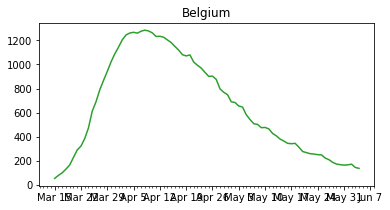

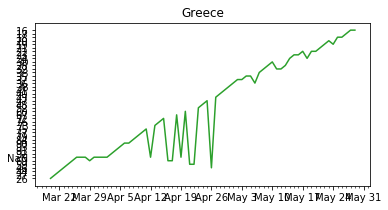

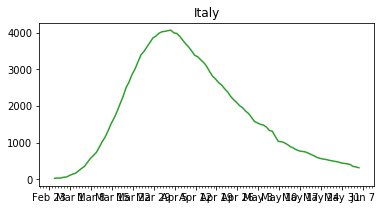

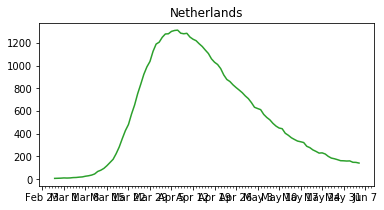

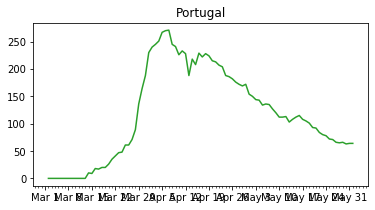

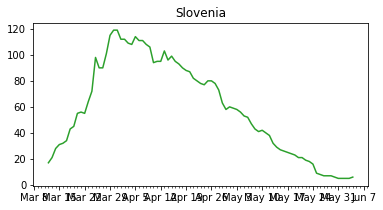

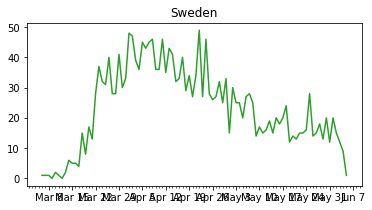

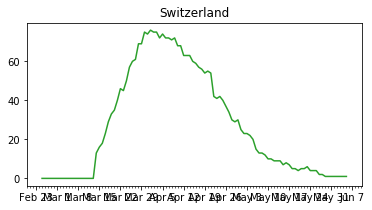

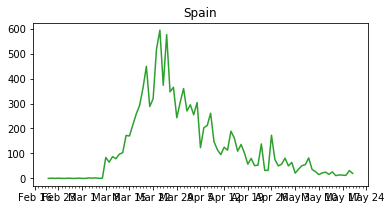

In [29]:
for key in icu:
    print(key)
    ax = cov19.plot._timeseries(icu[key]["date"],icu[key]["cases"],what="model")
    cov19.plot._format_date_xticks(ax)
    ax.set_title(key)